In [1]:
import sys
sys.path.append('..')
from evaluation.generated_dataset import load_all_from_config, GeneratedDataset
import pandas as pd

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [3]:
train_val_ = load_all_from_config(datasets=[("split", "train"), ("split", "val")], dataset_name="mpts_52")
train_val = pd.concat((d.data for d in train_val_.values()), axis=0, ignore_index=False)

In [4]:
test = GeneratedDataset.from_cache(("split", "test"), "mpts_52").data

In [5]:
wt = GeneratedDataset.from_cache(("WyckoffTransformer", )).data.sample(len(test), random_state=42)

In [6]:
from itertools import chain
from collections import Counter

In [7]:
def collect_tokens(fingerprint):
    return sum((Counter(dict(fs)) for fs in fingerprint[1]), Counter())

def record_to_token_counter(row):
    """
    Produces a non-augmented token counter from a row
    """
    return Counter(
        map(tuple, zip(row["elements"], row["site_symmetries"], row["sites_enumeration"])))

In [8]:
test_token_counts = test.apply(record_to_token_counter, axis=1).sum()

In [9]:
augmented_test_token_counts = test.fingerprint.apply(collect_tokens).sum()

In [10]:
train_val_token_counts = train_val.fingerprint.apply(collect_tokens).sum()

In [11]:
wt_token_counts = wt.apply(record_to_token_counter, axis=1).sum()

In [12]:
len(test)

8096

In [13]:
len(test_token_counts.keys() - train_val_token_counts.keys())

323

1. There are no precise details on how many tokens were formed from the MP-20 dataset after tokenization. It would be interesting to discuss this number and other statistics about the tokens, e.g., which tokens are present more often (for some of the high symmetry space groups) and how the distribution of tokens affects training.

In [14]:
mp_20_token_counts = augmented_test_token_counts + train_val_token_counts

In [15]:
len(mp_20_token_counts)

11074

In [16]:
mp_20_token_freq_pd = pd.Series(mp_20_token_counts).sort_values(ascending=False)
mp_20_token_freq_pd /= mp_20_token_freq_pd.sum()

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


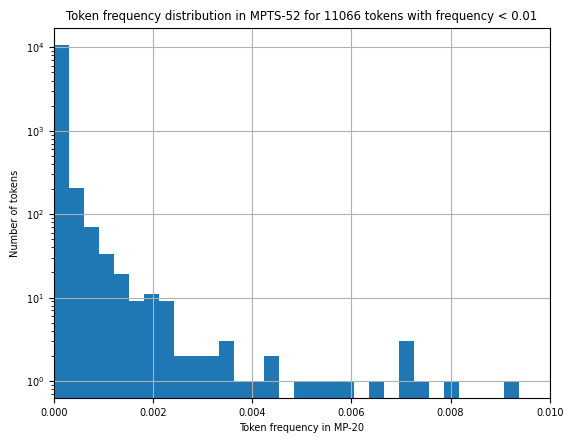

In [33]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
mp_20_token_freq_pd.hist(bins=500, ax=ax)
threshold = 0.01
ax.set_xlim(0, threshold)
ax.set_xlabel("Token frequency in MP-20")
ax.set_ylabel("Number of tokens")
ax.set_yscale("log");
ax.set_title(f"Token frequency distribution in MPTS-52 for {(mp_20_token_freq_pd < 0.01).sum()} tokens with frequency < {threshold}");

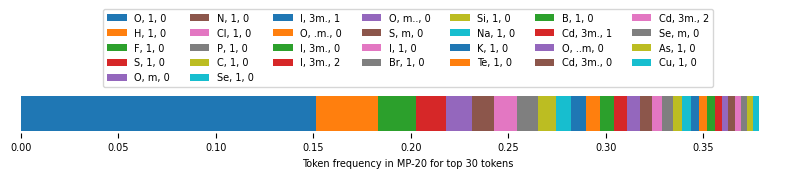

In [34]:

font = {'size': 7}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10, 0.5))
start = 0
top_count = 30
cmap = matplotlib.colormaps['tab10']
for i, (token, frequency) in enumerate(mp_20_token_freq_pd.iloc[:top_count].items()):
    ax.barh(0, frequency, left=start, color=cmap(i % cmap.N), label=f"{token[0]}, {token[1]}, {token[2]}")
    start += frequency
ax.set_yticks([])
ax.set_xlabel(f"Token frequency in MP-20 for top {top_count} tokens")
ax.legend(ncol=7, bbox_to_anchor=(0.5, 2.2), loc='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

2. It is also important to add how many new tokens the method generates or if it just predicts the fixed set of tokens in different combinations (and these combinations result in more template novelty than just sampling existing templates from training data). For instance, naively thinking about it, how will your model generate tokens that are not present in its dictionary?


In [20]:
print(len(wt_token_counts.keys() - train_val_token_counts.keys()), len(test_token_counts.keys() - train_val_token_counts.keys()))

610 323


In [21]:
len(wt_token_counts.keys() - train_val_token_counts.keys())/len(wt)*28

2.109683794466403

3. Another thing is that the token space is relatively smaller, so how can it be argued that these tokens cover all possible values a token could take in real material? Since we do not expect to see new tokens during generation, it should be added as a limitation of the method.

In [22]:
(wt_token_counts - train_val_token_counts).most_common(10)

[((Element Mo, '3m.', 0), 33),
 ((Element F, 'm', 1), 33),
 ((Element Mn, 'm', 0), 32),
 ((Element Mo, '3m.', 2), 31),
 ((Element W, '3m.', 0), 24),
 ((Element W, '3m.', 2), 23),
 ((Element Pm, 'm-3m', 0), 22),
 ((Element Pm, 'm-3m', 1), 21),
 ((Element Rh, '-43m', 0), 20),
 ((Element Te, '3m.', 2), 18)]

In [23]:
len(wt)-wt.fingerprint.isin(train_val.fingerprint).sum()

7707

In [24]:
75*81*8

48600

In [25]:
import gzip
import pickle
with gzip.open("../cache/wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    a, letter_from_ss_enum, ss_from_letter = pickle.load(f)

In [26]:
all_ss = frozenset(chain(*((s.values() for s in ss_from_letter.values()))))

In [30]:
missing_ss = all_ss - frozenset(mp_20_token_freq_pd.index.get_level_values(1).unique())

In [31]:
missing_ss

frozenset({'42.2', '6..', '622'})